# Monte Carlo Simulation

Working with Lennard-Jones potential today. $$U(r) = 4\epsilon \left [ \left( \frac{\sigma}{r} \right )^{12} - \left( \frac{\sigma}{r} \right )^6 \right ]$$

Reduced equation: $$ U^*\left(r_{ij} \right) = 4 \left[\left(\frac{1}{r^*_{ij}}\right)^{12} -\left(\frac{1}{r^*_{ij}}\right)^{6} \right] $$


In [20]:
import math

In [2]:
def calculate_LJ(r_ij):
    """
    The LJ interaction energy between two particles.
    
    Computes the pairwise Lennard-Jones interaction energy based on the separation distance in reduced units.
    
    Parameters:
    ```````````
    r_ij : float
        The separation distance in reduced units.
    
    Returns:
    ````````
    pairwise energy : float
        The pairwise Lennard-Jones interaction energy in reduced units.
    """
    
    inverse = 1/r_ij
    pairwise_energy = 4 *(math.pow(inverse, 12) - math.pow(inverse, 6))
    return pairwise_energy

In [3]:
assert calculate_LJ(1) == 0
assert calculate_LJ(math.pow(2, 1/6)) == -1

In [4]:
def calculate_distance(coord1, coord2, box_length = None):
    """
    Calculate the distance between two points. When box_length is set, we use the the minimum image convention to calculate.
    
    Parameters:
    ```````````
    coord1, coord2 : list
        The atomic coordinates [x, y, z]
        
    box_length : float, optional
        The box length. The function assumes the box is a cube.
    
    Returns:
    ````````
    distance : float
        The distance between the two atoms.
    """
    distance = 0
    for i in range(len(coord1)):
        coord_dist = coord1[i] - coord2[i]
        if box_length:
            if abs(coord_dist) > box_length / 2:
                coord_dist = coord_dist - (box_length * round(coord_dist / box_length))
        distance += coord_dist**2
        
    distance = math.sqrt(distance)
    
    return distance

In [5]:
point1 = [0,0,0]
point2 = [0,0,8]

dist1 = calculate_distance(point1, point2, box_length = 10)
assert dist1 == 2

point3 = [0,0,0]
point4 = [0,1,1]

dist2 = calculate_distance(point3, point4)
assert dist2 == math.sqrt(2)

In [6]:
coordinates = [[0, 0, 0], [0, math.pow(2, 1/6), 0], [0, 2*math.pow(2, 1/6), 0]]

In [13]:
def calculate_total_energy(coords, box_length, cutoff):
    """
    Calculates the total interaction energy existing among a set of coordinates.
    
    Parameters:
    ```````````
    coords : list
        Nested list of coordinates [x,y,z]
    cutoff : float
        The cutoff distance for the system
        
    Returns:
    ````````
    total_energy : float
        The total interaction energy calculated from LJ potential.
    """
    
    total_energy = 0
    
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            dist = calculate_distance(coords[i], coords[j], box_length)
            if dist < cutoff:
                energy = calculate_LJ(dist)
                total_energy += energy
    
    return total_energy

In [56]:
def calculate_tail_correction(num_particles, box_length, cutoff):
    """
    Calculate the long range tail correction
    """
    
    const1 = (8 * math.pi * num_particles ** 2) / (3 * box_length ** 3)
    const2 = (1/3) * (1 / cutoff)**9 - (1 / cutoff) **3
    
    return const1 * const2


## Calculating energy from NIST data

In [9]:
import os

In [10]:
def read_xyz(filepath):
    """
    Reads coordinates from an xyz file.
    
    Parameters
    ----------
    filepath : str
       The path to the xyz file to be processed.
       
    Returns
    -------
    atomic_coordinates : list
        A two dimensional list containing atomic coordinates
    """
    
    with open(filepath) as f:
        box_length = float(f.readline().split()[0])
        num_atoms = float(f.readline())
        coordinates = f.readlines()
    
    atomic_coordinates = []
    
    for atom in coordinates:
        split_atoms = atom.split()
        
        float_coords = []
        
        # We split this way to get rid of the atom label.
        for coord in split_atoms[1:]:
            float_coords.append(float(coord))
            
        atomic_coordinates.append(float_coords)
        
    
    return atomic_coordinates, box_length


In [11]:
filename = os.path.join('lj_sample_configurations', 'lj_sample_config_periodic1.txt')
atomic_coordinates, box_length = read_xyz(filename)

In [17]:
assert math.isclose(calculate_total_energy(atomic_coordinates, box_length, 3), -4.3515E+03, rel_tol = 0.01)

## Flow of Calculations

1. Generate an initial system state `m`
2. Choose an atom with uniform probability from state `m`
3. Propose a new state `n` by translating the particle with a uniform random displacement in each direction
4. Calculate the energy change for the particle
5. Accept or reject new state

In [22]:
import random

In [30]:
def accept_or_reject(delta_e, beta):
    """
    Accept or reject a new state based on change in energy and temperature.
    
    Parameters:
    ```````````
    delta_e : float
        change in energy
    
    beta : float
        inverse of temperature
        
    Returns:
    ````````
    accept : bool
        T/F value of whether to accept change
    """
    if delta_e == 0:
        accept = True
    else:
        random_number = random.random()
        p_acc = math.exp(-beta * delta_e)
        
        if random_number < p_acc:
            accept = True
        else:
            accept = False
    
    return accept

In [31]:
delta_energy = -1
beta = 1
assert accept_or_reject(delta_energy, beta) is True

delta_energy = 0
beta = 1
assert accept_or_reject(delta_energy, beta) is True

In [32]:
random.seed(0)
delta_energy = 1
beta = 1
assert accept_or_reject(delta_energy, beta) is False

0.36787944117144233


In [33]:
random.seed(1)
delta_energy = 1
beta = 1
assert accept_or_reject(delta_energy, beta) is True

In [34]:
random.seed()

In [40]:
def calculate_pair_energy(coordinates, i_particle, box_length, cutoff):
    """
    Calculates the interaction energy of one particle with all others in system.
    
    Parameters:
    ```````````
    coordinates : list
       nested list of [x,y,z] coordinates for all particles in the system
        
    i_particle : int
        the particle index for which to calculate energy
        
    box_length : float
        the length of the simulation box
        
    cutoff : float
        the cutoff interaction length
        
    Returns:
    ````````
    e_total : float
        the pairwise energy between the i-th particle and other particles in system
    """
    e_total = 0
    for i in range(len(coordinates)):
        if i == i_particle:
            continue
        dist = calculate_distance(coordinates[i], coordinates[i_particle], box_length)
        if dist < cutoff:
            energy = calculate_LJ(dist)
            e_total += energy
    
    return e_total

In [41]:
coordinates = [[0,0,0], [0,0,2**(1/6)], [0,0,2*(2**(1/6))]]

assert calculate_pair_energy(coordinates, 1, 10, 3) == -2

assert calculate_pair_energy(coordinates, 0, 10, 3) == calculate_pair_energy(coordinates, 2, 10, 3)

## Simulation Loop

In [58]:
# set simulation parameters
reduced_temperature = 0.9
num_steps = 5000
max_displacement = 0.1
cutoff = 3

# reporting information
freq = 1000
steps = []
energies = []

# calculated quantities
beta = 1 / reduced_temperature

# read initial coordinates
file_path = os.path.join('lj_sample_configurations', 'lj_sample_config_periodic1.txt')
coordinates, box_length = read_xyz(file_path)
num_particles = len(coordinates)

total_energy = calculate_total_energy(coordinates, box_length, cutoff)
total_energy += calculate_tail_correction(num_particles, box_length, cutoff)

for step in range(num_steps):
    # 1. randomly pick one of num_particles with uniform distribution
    random_particle = random.randrange(0, num_particles)
    
    # 2. calculate the interaction energy of selected particle with system.
    current_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # 3. generate random x, y, z displacement range (-max_displacement, max_displacement)
    x_rand = random.uniform(-max_displacement, max_displacement)
    y_rand = random.uniform(-max_displacement, max_displacement)
    z_rand = random.uniform(-max_displacement, max_displacement)
    
    # 4. modify coordinate of selected particle by generated displacements
    coordinates[random_particle][0] += x_rand
    coordinates[random_particle][1] += y_rand
    coordinates[random_particle][2] += z_rand
    
    # 5. calculate new interaction energy of moved particle.
    proposed_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # 6. calculate energy change and decide to accept / reject.
    delta_energy = proposed_energy - current_energy
    accept = accept_or_reject(delta_energy, beta)
    
    # 7. if accept, keep movement. if not revert to old position
    if accept:
        total_energy += delta_energy
    else:
        coordinates[random_particle][0] -= x_rand
        coordinates[random_particle][1] -= y_rand
        coordinates[random_particle][2] -= z_rand
    
    # 8. print energy at certain intervals
    if step % freq == 0:
#         print(step, total_energy/num_particles)
        steps.append(step)
        energies.append(total_energy/num_particles)


0 -5.687536347860019
1000 -5.66903005465288
2000 -5.662595809911927
3000 -5.675320991685661
4000 -5.713791338374543


<IPython.core.display.Javascript object>


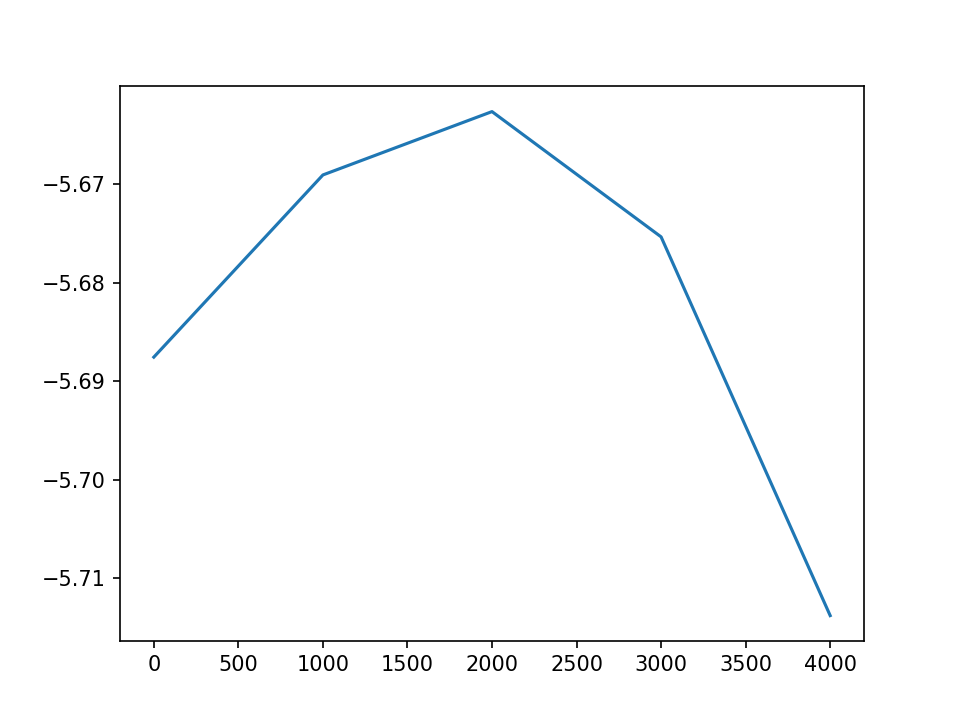

In [60]:
import matplotlib.pyplot as plt

%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(steps, energies)